## Sounddevice

python-sounddevice allows you to record audio from your microphone and store it as a NumPy array.

This is a handy datatype for sound processing that can be converted to WAV format for storage using the scipy.io.wavfile module.

In [1]:
import sounddevice as sd
from scipy.io.wavfile import write, read
from scipy.signal import csd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import correlate
from IPython.display import Audio
%matplotlib inline




In [17]:

fs = 44100  # Sample rate
seconds = 3  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  # Wait until recording is finished
sd.play(myrecording)  

In [18]:
sd.play(myrecording, fs)

Methods for generating channel response

1. Play impulse file (e.g. 10-20 frames long, rest are zeros)
    - Generate the burst white noise with python 
    - Transmit the wav file to phone and play the audio file on phone, record the transmitted audio with python
    - 
2. Compare auto & cross-correlation functions

$$
    r_{XY}(\tau) = h(\tau) \star r_{XX}(\tau) \quad \rightarrow^{\textrm{F.T.}} \quad S_{XY}(\tau) = H(\tau) S_X(\tau)
$$



### 0. Set all the paramaters

In [4]:
fs = 44100  # Sample rate
seconds = 3  # Duration of sample .wav
L = 1000 #channel response length
N = 1000 #block length (of OFDM?)
W = 1000000 #bandwidth (of OFDM?)

thresh_divider=40 #for triming the received audio

### 1. Generate a burst white noise

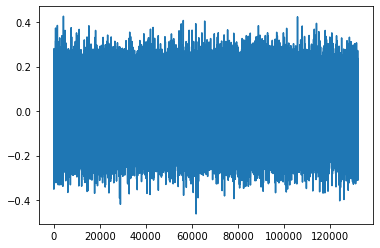

In [5]:


# Mean, Standard Deviation, num_samples
noise = np.random.normal(0,0.1, fs*seconds)
plt.plot(noise)

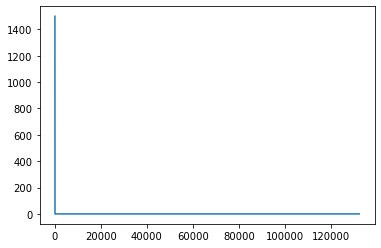

In [6]:
# Amplify the initial part of the audio
# to create an impulse/burst
impulse = 0.5 # length of impulse in second
Burst_noise = 0.1*noise
# sample_length=int(impulse * fs)
# sample_length=5
# Burst_noise[0:sample_length] = 100 *  noise[0: sample_length]
Burst_noise[0]=1500 # this is simply setting the first value to be positively high
plt.plot(Burst_noise)

In [7]:
# Save the numpy as wav audio file
write('test_noise.wav', fs, Burst_noise)

# Recording part:

##### you can either go through 2, 3 and 5 step by step, or jump to 6 to call the function all in one go

### 2. Record the burst noise from phone playback

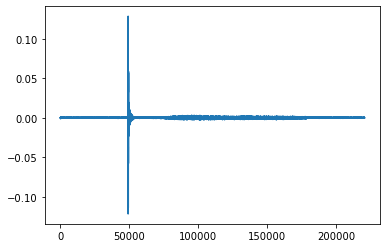

In [49]:
seconds = 5  # Use a slightly longer duration for recording and trim afterwards

recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
write('received_noise.wav', fs, recording)  # Save as WAV file 
plt.plot(recording)

### 3.0 Trim the audio 

In [50]:
### Automatically trim the audio
thresh=recording.max()/thresh_divider
print('thresh: ',thresh)
print('len(recording)',len(recording))


thresh:  0.0025678080320358275
len(recording) 220500


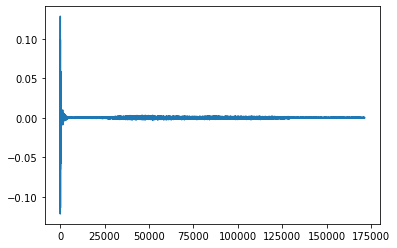

In [51]:
receive = np.delete(recording, np.arange(0, np.argmax(recording > thresh)))
plt.plot(receive)

### 3.1 Take the first 3 seconds of audio file

132300 132300


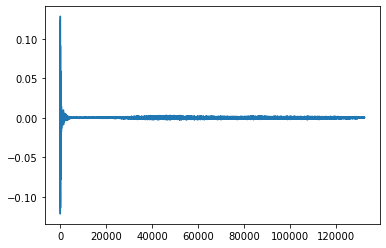

In [52]:
trimmed_receive = receive[0:(len(Burst_noise))]
# Check the length of the transmitted and received
print(len(trimmed_receive),len(Burst_noise))
plt.plot(trimmed_receive)

### 4 Normalise the transimitted and received audio

（Why do we need to normalise them?）

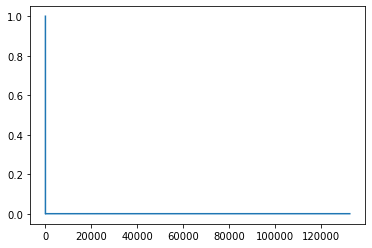

In [124]:
normalised_tran = Burst_noise / np.linalg.norm(Burst_noise)
plt.plot(normalised_tran)

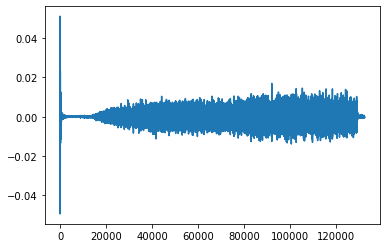

In [125]:
normalised_rece = trimmed_receive / np.linalg.norm(trimmed_receive)
plt.plot(normalised_rece)

### 5 Compute PSD and hence find channel response

In [53]:
len_seg=2000
f1,sxx=csd(Burst_noise,Burst_noise,fs,nperseg=len_seg)
print(len(sxx),f1)
f2,sxy=csd(Burst_noise,trimmed_receive,fs,nperseg=len_seg)
print(len(sxy),f2)


1001 [    0.      22.05    44.1  ... 22005.9  22027.95 22050.  ]
1001 [    0.      22.05    44.1  ... 22005.9  22027.95 22050.  ]


In [54]:
H=sxy/sxx
print(H)


[3.05843308e-05+0.00000000e+00j 3.00047106e-05+8.44005118e-06j
 6.78982349e-03-9.93377488e-03j ... 3.99265748e-09-2.51358234e-10j
 8.72862050e-10+8.53584505e-11j 9.98596696e-10+0.00000000e+00j]


[ 0.00126032+0.00485582j -0.00621923+0.0015332j  -0.00138791-0.0071119j
 ... -0.00169889+0.00045682j -0.0006693 -0.00236084j
  0.00343348-0.0008563j ]


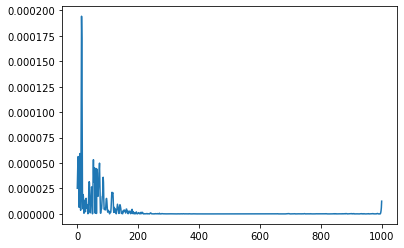

In [44]:
h=np.fft.ifft(H)
print(h)
plt.plot(np.real(h*np.conj(h)))

[ 8.50059255e-04-0.00028608j  6.71290074e-04+0.00131157j
 -1.70434939e-03+0.00120154j ... -4.85471082e-04+0.00062669j
 -7.26007113e-04-0.00017029j -9.08235569e-05-0.00067086j]


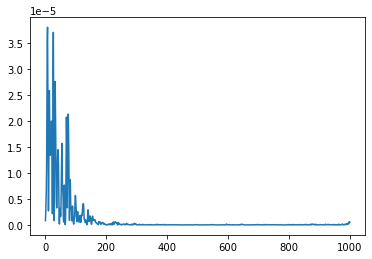

In [55]:
h=np.fft.ifft(H)
print(h)
plt.plot(np.real(h*np.conj(h)))

## 6. If you want to get the recording and analysing part all in one function:

In [60]:
def record_and_analyse():
    seconds = 5  # Use a slightly longer duration for recording and trim afterwards
    recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
    sd.wait()  # Wait until recording is finished
    write('received_noise.wav', fs, recording)  # Save as WAV file 
    
#     fig, ax = plt.subplots()
#     ax.plot(recording)
#     ax.set_title('recorded sound')
    
    ### Automatically trim the audio
    thresh=recording.max()/thresh_divider
#     print('thresh: ',thresh)
#     print('len(recording)',len(recording))
    receive = np.delete(recording, np.arange(0, np.argmax(recording > thresh)))
    
    trimmed_receive = receive[0:(len(Burst_noise))]
    # Check the length of the transmitted and received
#     print(len(trimmed_receive),len(Burst_noise))
    
#     fig, ax = plt.subplots()
#     ax.plot(trimmed_receive)
#     ax.set_title('trimed sound')
    
    # Compute PSD and do analysis
    len_seg=2000
    f1,sxx=csd(Burst_noise,Burst_noise,fs,nperseg=len_seg)
#     print(len(sxx),f1)
    f2,sxy=csd(Burst_noise,trimmed_receive,fs,nperseg=len_seg)
#     print(len(sxy),f2)
    
    H=sxy/sxx
    print('H',H)
    
    h=np.fft.ifft(H)
    print('h',h)
    fig, ax = plt.subplots()
    ax.plot(np.real(h*np.conj(h)))
    ax.set_title('magnitude of impulse response')

Call the function multiple times to get different measurements (note that the script will start recording as soon as you pressed 'run'):

H [ 1.21052281e-05+0.00000000e+00j  8.08062057e-06-7.97897608e-06j
 -1.83746450e-03-1.20256802e-03j ...  3.56664160e-09+4.24310301e-09j
  1.17511746e-09+1.49859063e-09j  2.28820050e-10+0.00000000e+00j]
h [-8.29103927e-04+0.00096192j -1.42398286e-03-0.00076977j
  7.53291639e-04-0.00186828j ... -3.59378320e-04+0.00025276j
  5.43692693e-05-0.00029565j  5.24308584e-04+0.00055854j]


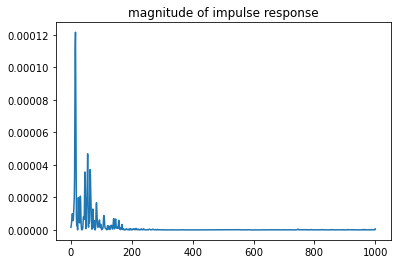

In [62]:
record_and_analyse()

H [ 2.39679313e-05+0.00000000e+00j  2.43526122e-05-2.78273364e-06j
 -2.25471559e-03-2.23900865e-03j ...  5.63843263e-09-5.56101254e-09j
  2.59459689e-09+6.23138676e-10j  4.34605888e-10+0.00000000e+00j]
h [ 1.30843063e-03+0.00135515j -1.68878822e-03+0.0017625j
 -2.47164102e-03-0.00219226j ...  5.55918647e-05+0.00026852j
 -3.29135540e-04-0.00049356j  1.02031242e-03-0.00077359j]


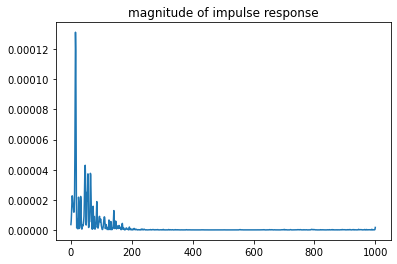

In [63]:
record_and_analyse()

H [ 1.27823388e-05+0.00000000e+00j  9.93255178e-06+3.92198934e-06j
  1.23253951e-03-2.97823383e-03j ... -1.90692574e-09+3.18145592e-09j
  3.66506482e-09+1.25694989e-09j  2.27765534e-09+0.00000000e+00j]
h [ 0.00089114+0.00195432j -0.00247561+0.00117849j -0.00155976-0.00308721j
 ... -0.00074636+0.00034587j -0.00050202-0.00109143j
  0.00150382-0.00066349j]


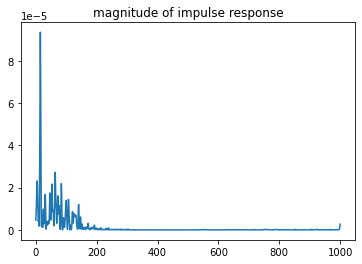

In [64]:
record_and_analyse()

H [ 2.07787798e-05+0.00000000e+00j  1.25827239e-05-4.12599670e-06j
 -7.30510183e-03+4.06070940e-03j ...  2.71096178e-09+3.46006963e-09j
  3.30371641e-09-2.25806856e-09j  2.89059186e-09+0.00000000e+00j]
h [-1.24014969e-04+9.95565279e-04j -1.45990744e-03-1.47719869e-04j
  4.48767592e-05-1.92094236e-03j ... -1.26171039e-04+1.93993736e-04j
 -1.44932855e-04-3.87843400e-04j  6.79385458e-04-2.26089728e-05j]


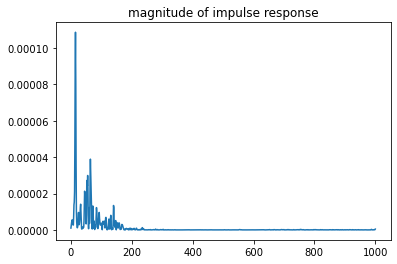

In [65]:
record_and_analyse()